In [5]:
from feature_engine.datetime import DatetimeFeatures
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, SplineTransformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
import sys
from xgboost import XGBRegressor

sys.path.append(str(Path().absolute().parent.parent))

from tsml.train.trainer import TSTrainer, CustomTimeSeriesSplit

In [6]:
# df = pd.read_parquet('../../data/walmart/processed/cat_id_sales.parquet').replace(-1, np.nan).dropna()
df = pd.read_parquet('../../data/walmart/processed/cat_id_sales.parquet').dropna()
df.shape

(5736, 26)

In [89]:
def multi_ts_train_test_split(X, y, window_split): ## test_size equal to the time horizon. Splits defines the rest
        if isinstance(X.index, pd.core.indexes.range.RangeIndex):
            idx_u = np.unique(X.index.values)
        else: 
            idx_u = X.index.unique()

        train_index = idx_u[ : -window_split]
        test_index  = idx_u[ -window_split : ]
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        return X_train, X_test, y_train, y_test

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation='periodic',
        include_bias=True,
    )

In [61]:
targets = ['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7','y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13']
X_train, X_test, y_train, y_test = \
    multi_ts_train_test_split(df.set_index('date', drop=False), df.set_index('date', drop=False)[targets], 28)

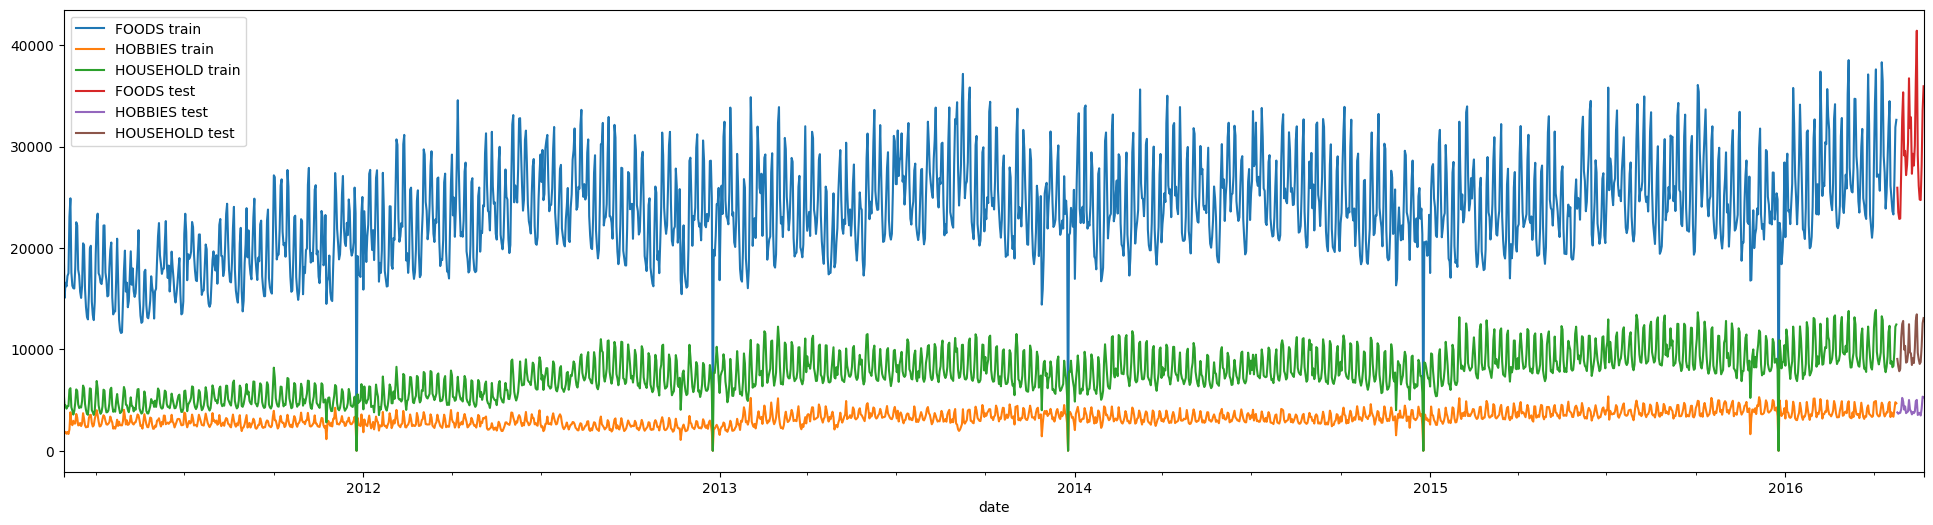

In [9]:
fig, ax= plt.subplots(figsize=(24,6))
for name, group in X_train.groupby('cat_id'):
    group.plot(y = 'y_0', ax=ax, label=f'{name} train')
for name, group in X_test.groupby('cat_id'):
    group.plot(y = 'y_0', ax=ax, label=f'{name} test')
plt.show()

In [115]:
categorical_columns_ohe = ['cat_id']
categorical_columns_ordinal = ['event_name_1', 'event_name_2']
date_column = ['date']
targets = ['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7','y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13']

dt_transform = DatetimeFeatures(
    variables='date',
    features_to_extract=['year','month','week','day_of_week', 'day_of_month']
)

ohe = OneHotEncoder()
ordinal = OrdinalEncoder()

transformer_1 = ColumnTransformer(
        transformers=[
            ('date_transform', dt_transform, date_column),
            ('categorical-ordinal', ordinal, categorical_columns_ordinal),
            ('categorical-ohe', ohe, categorical_columns_ohe),
            ('drop', 'drop', targets)
        ],
        remainder='passthrough',
    )

transformer_2 = make_pipeline(
    dt_transform,
    ColumnTransformer(
        transformers=[
            ('cyclic_month', periodic_spline_transformer(12, n_splines=6),  ['date_month']),
            ('cyclic_weekday', periodic_spline_transformer(7, n_splines=3), ['date_day_of_week']),
            ('cyclic_week', periodic_spline_transformer(52, n_splines=24),  ['date_week']),
            ('categorical-ordinal', ordinal, categorical_columns_ordinal),
            ('categorical-ohe', ohe, categorical_columns_ohe),
            ('drop', 'drop', targets)
        ],
        remainder='passthrough',
    )
)

xgb_pipeline_1 = make_pipeline(transformer_1, XGBRegressor())
xgb_pipeline_2 = make_pipeline(transformer_2, XGBRegressor())
lgbm_pipeline_1 = make_pipeline(transformer_1,LGBMRegressor())
lgbm_pipeline_2 = make_pipeline(transformer_2,LGBMRegressor())

(15,)
['cyclic_week__date_week_sp_0' 'cyclic_week__date_week_sp_1'
 'cyclic_week__date_week_sp_2' 'cyclic_week__date_week_sp_3'
 'cyclic_week__date_week_sp_4' 'cyclic_week__date_week_sp_5'
 'cyclic_week__date_week_sp_6' 'cyclic_week__date_week_sp_7'
 'cyclic_week__date_week_sp_8' 'cyclic_week__date_week_sp_9'
 'cyclic_week__date_week_sp_10' 'cyclic_week__date_week_sp_11'
 'cyclic_week__date_week_sp_12' 'cyclic_week__date_week_sp_13'
 'cyclic_week__date_week_sp_14']


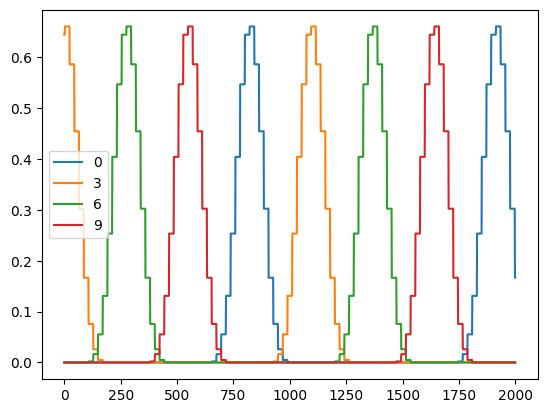

In [122]:

transformer_3 = make_pipeline(
    dt_transform,
    ColumnTransformer(
        transformers=[
            # ('cyclic_month', periodic_spline_transformer(12, n_splines=6),  ['date_month'])
            # ('cyclic_weekday', periodic_spline_transformer(7, n_splines=3), ['date_day_of_week']),
            ('cyclic_week', periodic_spline_transformer(52, n_splines=12),  ['date_week'])
        ],
        remainder='drop',
    )
)

X_transform = transformer_3.fit_transform(X_train[['date']])
columns = transformer_3.get_feature_names_out()
print(columns.shape)
print(columns)
pd.DataFrame(X_transform).iloc[:2000, 0:11:3].plot()
plt.show()

In [47]:
xgb_pipeline_1.fit(X_train, y_train['y_0'])
xgb_pipeline_2.fit(X_train, y_train['y_0'])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('datetimefeatures',
                                  DatetimeFeatures(features_to_extract=['year',
                                                                        'month',
                                                                        'week',
                                                                        'day_of_week',
                                                                        'day_of_month'],
                                                   variables='date')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cyclic_month',
                                                                   SplineTransformer(extrapolation='periodic',
                                                                                     knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [48]:
lgbm_pipeline_1.fit(X_train, y_train['y_0'])
lgbm_pipeline_2.fit(X_train, y_train['y_0'])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('datetimefeatures',
                                  DatetimeFeatures(features_to_extract=['year',
                                                                        'month',
                                                                        'week',
                                                                        'day_of_week',
                                                                        'day_of_month'],
                                                   variables='date')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cyclic_month',
                                                                   SplineTransformer(extrapolation='periodic',
                                                                                     knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10...
       [43.33333333],
       [45.5       ],
       [47.66666667],
       [49.83333333],
       [52.        ]]),
                                                                                     n_knots=25),
                                                                   ['date_week']),
                                                                  ('categorical-ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['event_name_1',
                                                                    'event_name_2']),
                                                                  ('categorical-ohe',
                                                                   OneHotEncoder(),
                                                                   ['cat_id']),
                                                                  ('drop',
                                                                   'drop',
                                                                   ['y_0',
                                                                    'y_1',
                                                                    'y_2',
                                                                    'y_3',
                                                                    'y_4',
                                                                    'y_5',
                                                                    'y_6',
                                                                    'y_7',
                                                                    'y_8',
                                                                    'y_9',
                                                                    'y_10',
                                                                    'y_11',
                                                                    'y_12',
                                                                    'y_13'])]))])),
                ('lgbmregressor', LGBMRegressor())])

In [65]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 4,
    'num_leaves': 15,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'boosting_type': 'gbdt'
}

quantiles = [.05, .1, .25, .5, .75, .9, .95]
predictions_1 = {}
predictions_2 = {}
for q in quantiles:
    lgbm_model_1 = make_pipeline(transformer_1,LGBMRegressor(alpha=q, **params))
    lgbm_model_2 = make_pipeline(transformer_2,LGBMRegressor(alpha=q, **params))
    lgbm_model_1.fit(X_train, y_train['y_0'])
    lgbm_model_2.fit(X_train, y_train['y_0'])
    predictions_1[f'{q}'] = lgbm_model_1.predict(X_test)
    predictions_2[f'{q}'] = lgbm_model_2.predict(X_test)

In [66]:
y_test['cat_id'] = X_test['cat_id']
y_test['xgb_1'] = xgb_pipeline_1.predict(X_test)
y_test['lgbm_1'] = lgbm_pipeline_1.predict(X_test)
y_test['xgb_2'] = xgb_pipeline_2.predict(X_test)
y_test['lgbm_2'] = lgbm_pipeline_2.predict(X_test)

for k, v in predictions_1.items():
    y_test[f'lgbm_q1_{k}'] = v

for k, v in predictions_2.items():
    y_test[f'lgbm_q2_{k}'] = v

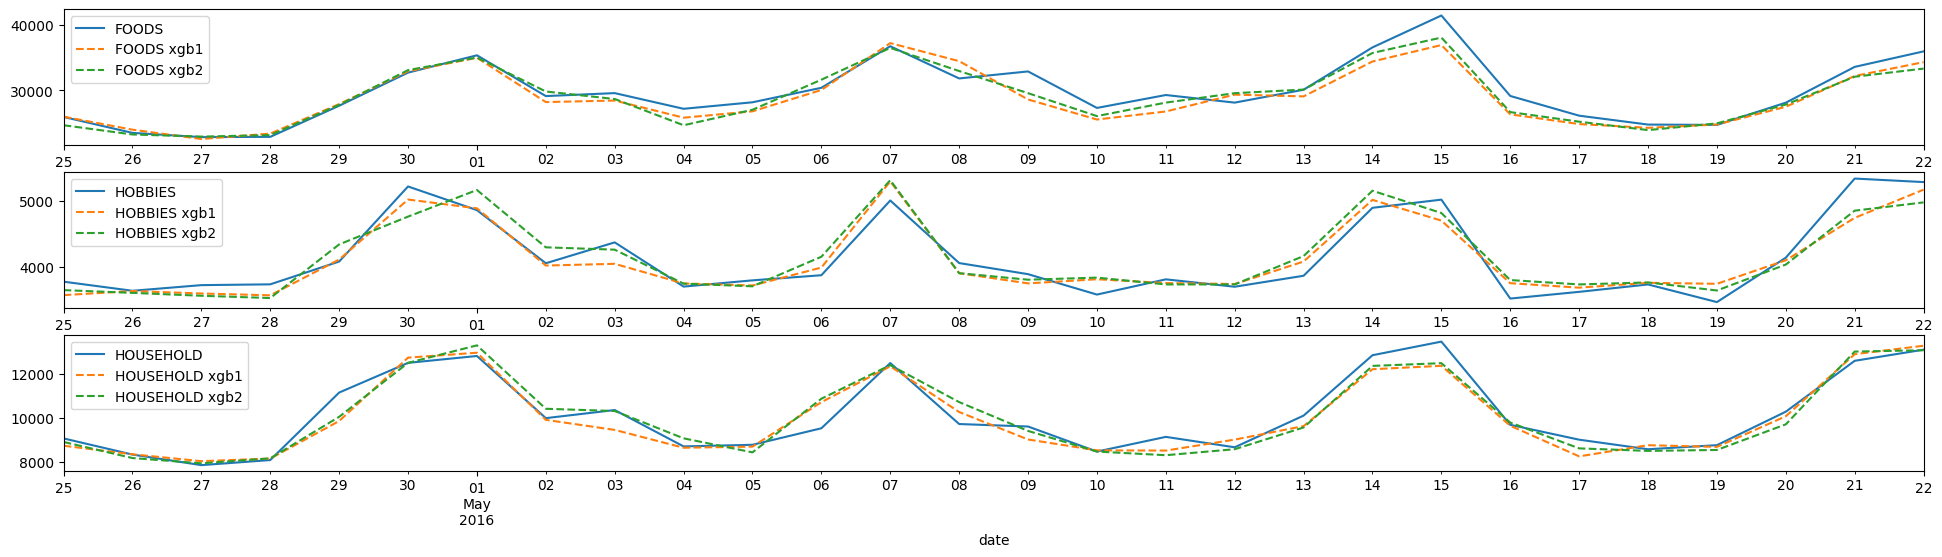

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24,6))

for (name, group), ax in zip(y_test.groupby('cat_id'), (ax1, ax2, ax3)):
    group.plot(y='y_0', ax=ax, linestyle= 'solid', label=name)
    group.plot(y='xgb_1', ax=ax, linestyle= 'dashed', label=f'{name} xgb1')
    group.plot(y='xgb_2', ax=ax, linestyle= 'dashed', label=f'{name} xgb2')

plt.show()

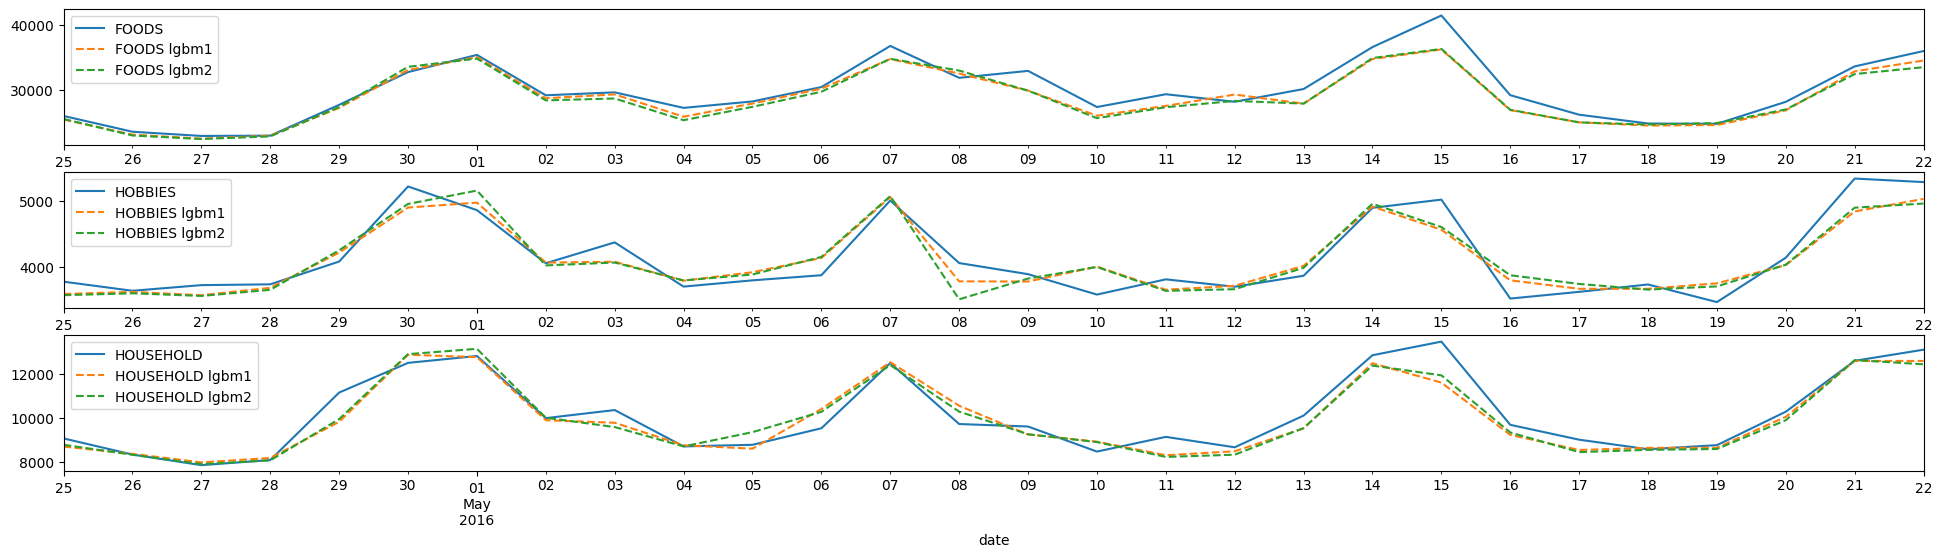

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24,6))

for (name, group), ax in zip(y_test.groupby('cat_id'), (ax1, ax2, ax3)):
    group.plot(y='y_0', ax=ax, linestyle= 'solid', label=name)
    group.plot(y='lgbm_1', ax=ax, linestyle= 'dashed', label=f'{name} lgbm1')
    group.plot(y='lgbm_2', ax=ax, linestyle= 'dashed', label=f'{name} lgbm2')

plt.show()

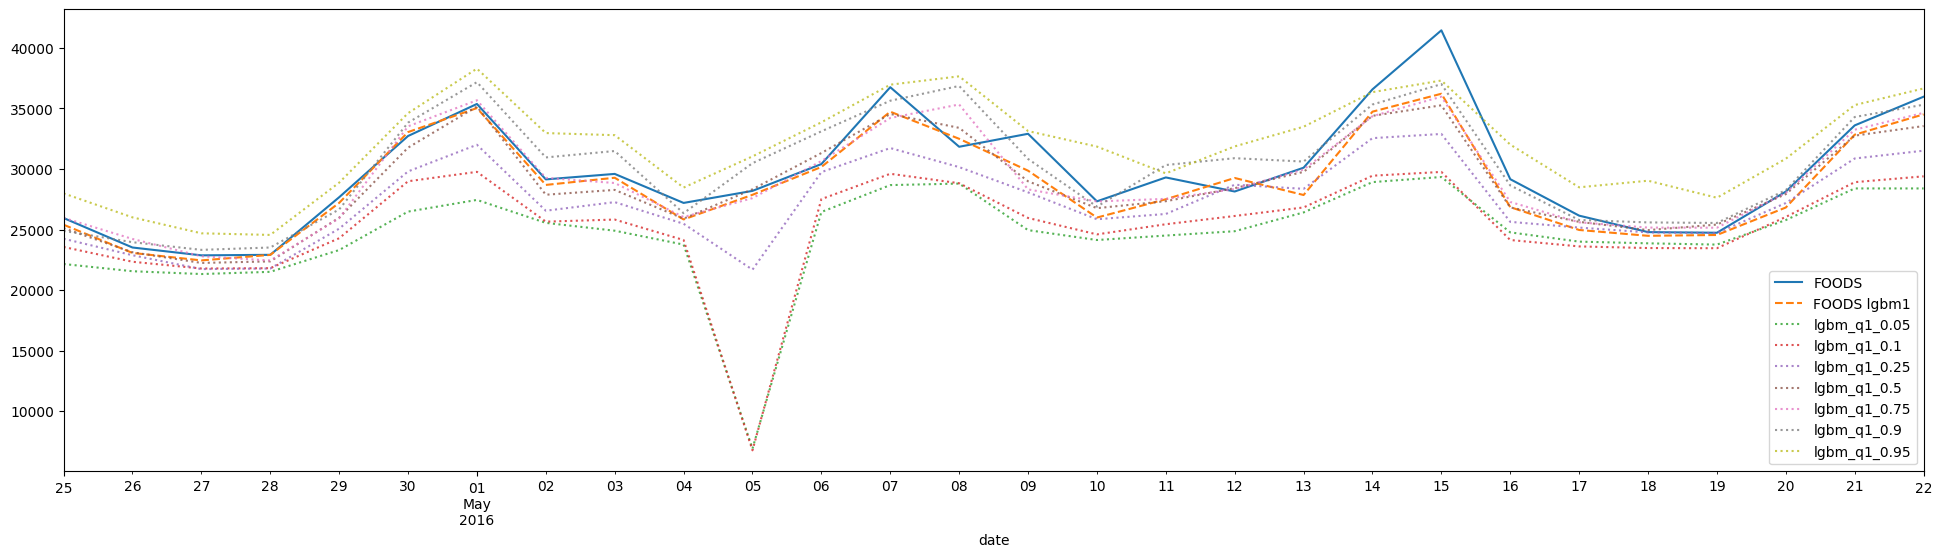

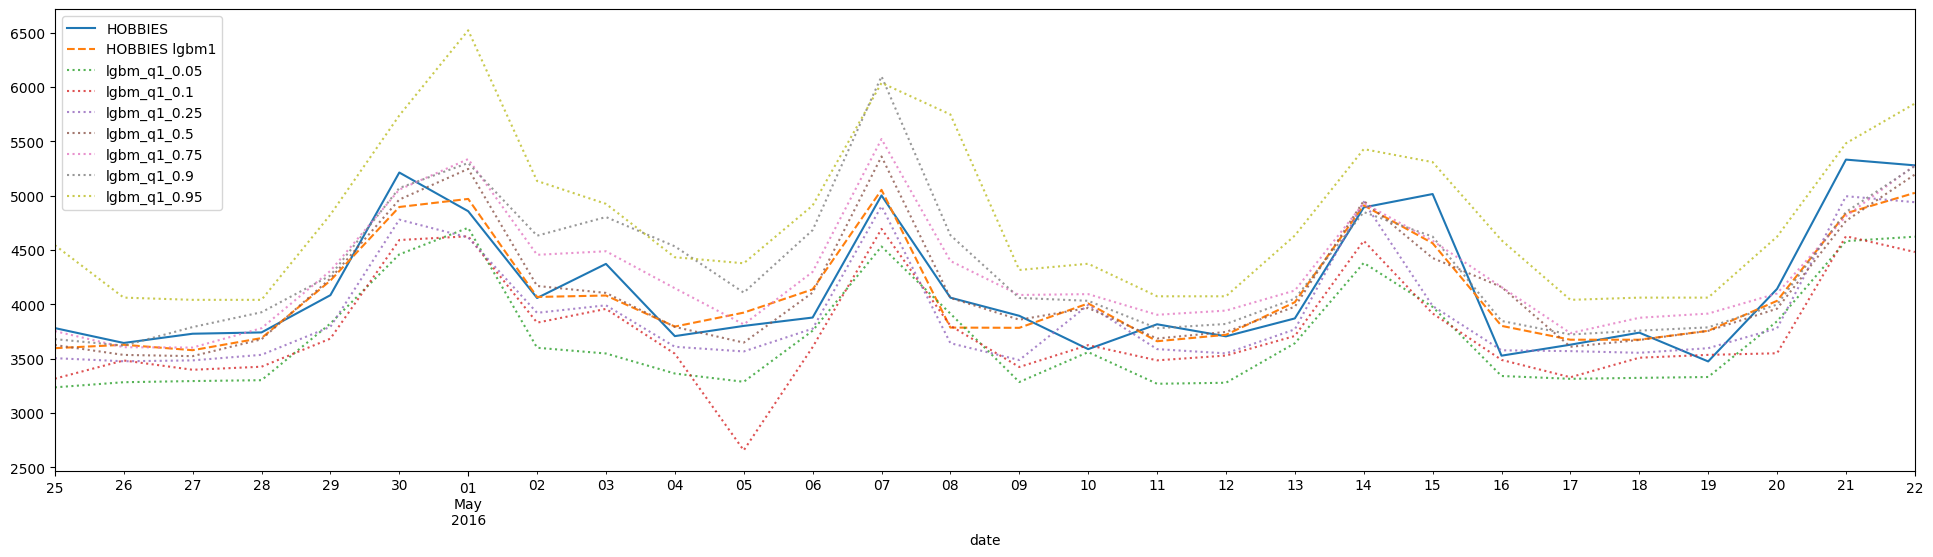

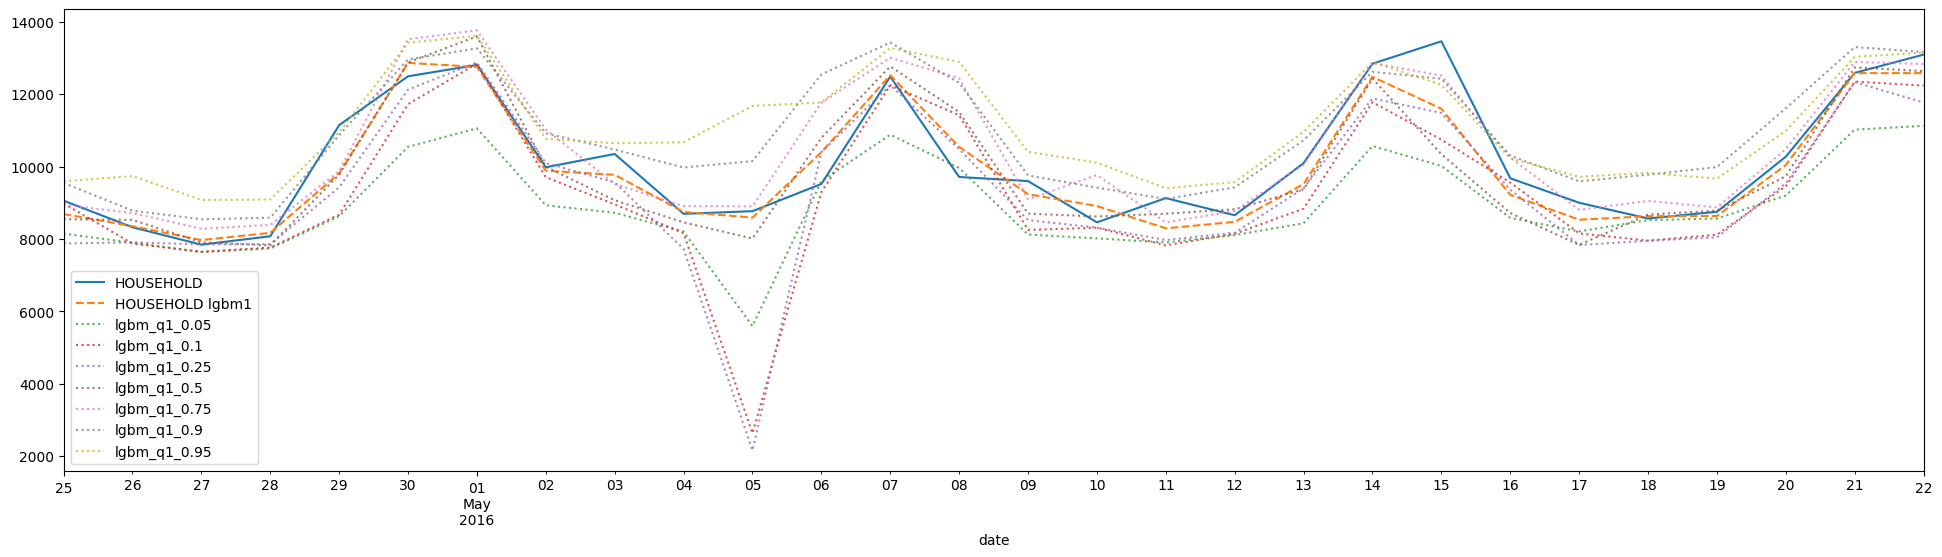

In [67]:
for (name, group) in y_test.groupby('cat_id'):
    fig, ax= plt.subplots(figsize=(24,6))
    group.plot(y='y_0', ax=ax, linestyle= 'solid', label=name)
    group.plot(y='lgbm_1', ax=ax, linestyle= 'dashed', label=f'{name} lgbm1')
    for col in [c for c in y_test.columns if 'q1' in c]:
        group.plot(y=col, ax=ax, linestyle= 'dotted', label=f'{col}', alpha=0.8)

plt.show()

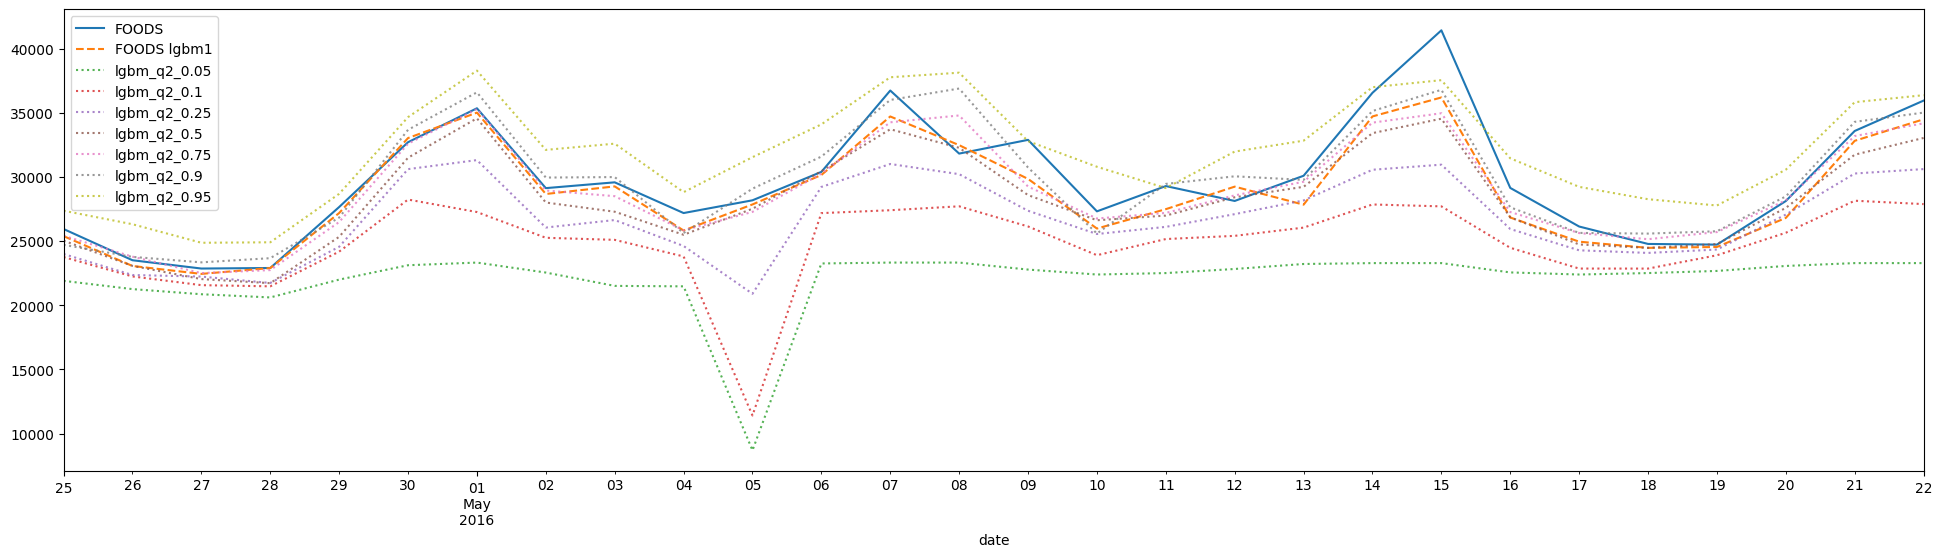

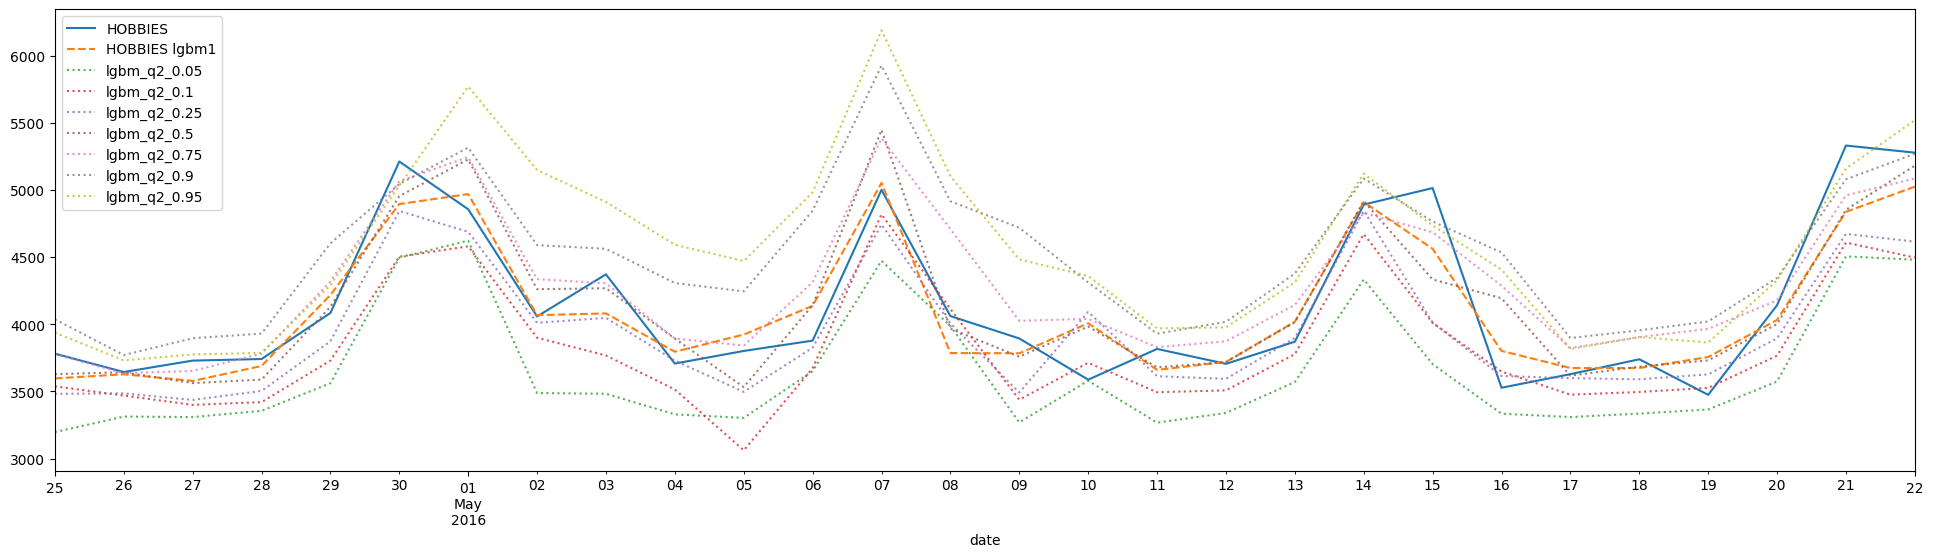

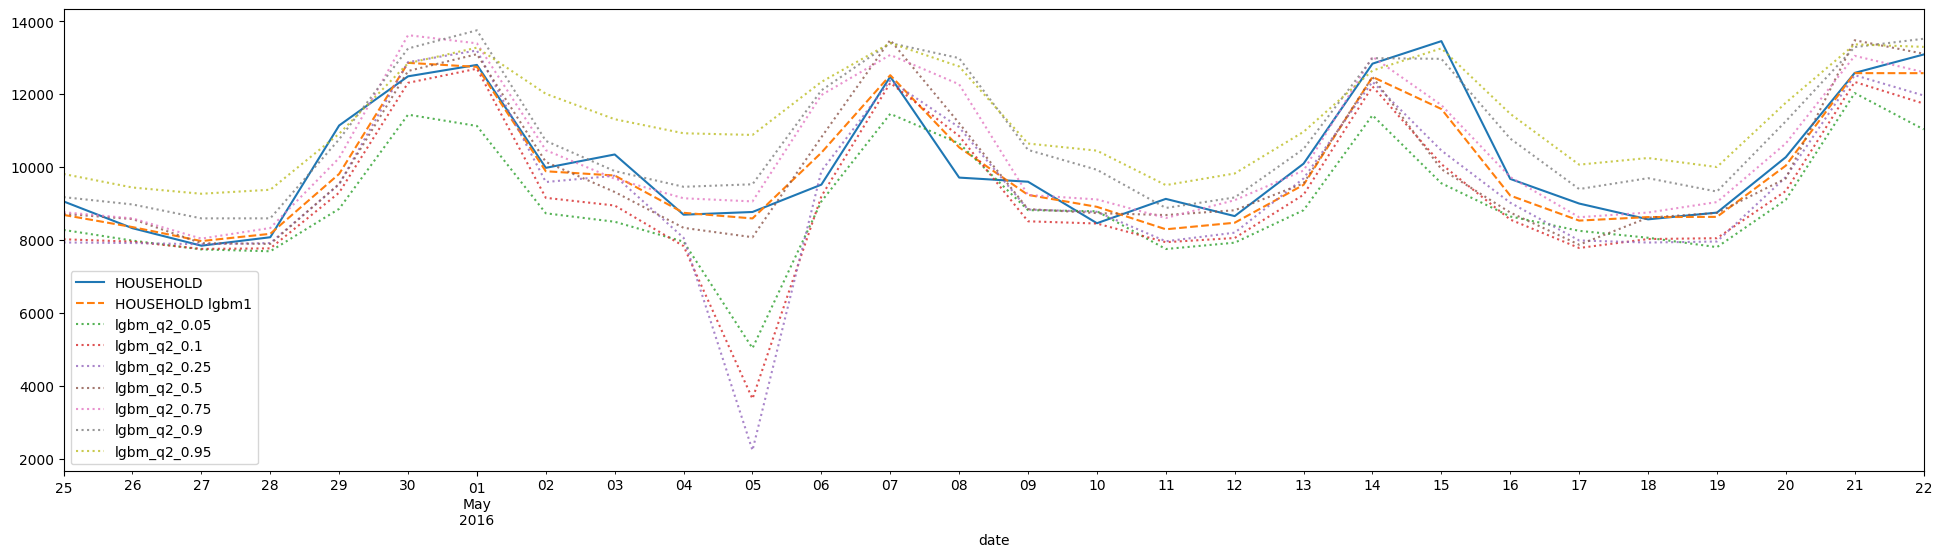

In [68]:
for (name, group) in y_test.groupby('cat_id'):
    fig, ax= plt.subplots(figsize=(24,6))
    group.plot(y='y_0', ax=ax, linestyle= 'solid', label=name)
    group.plot(y='lgbm_1', ax=ax, linestyle= 'dashed', label=f'{name} lgbm1')
    for col in [c for c in y_test.columns if 'q2' in c]:
        group.plot(y=col, ax=ax, linestyle= 'dotted', label=f'{col}', alpha=0.8)

plt.show()